This example notebook shows how we can train an image classification model, as described [here](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb),
and store it as TileDB array. Firstly, let's import what we need.

In [1]:
import tensorflow as tf
import tiledb
import os
import glob
import json
import pickle
import matplotlib.pyplot as plt

from pprint import pprint

from tiledb.ml.models.tensorflow_keras import TensorflowKerasTileDBModel

Load MNIST dataset for Keras datasets and scale.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

We can then define a function that creates a basic digit classifier for the MNIST dataset.

In [3]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10)
    ])

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])

    return model

We can then train a model using some of our data. Let's assume that we initially train with the first 30000
observations from our dataset.

In [4]:
model = create_model()
cb = [tf.keras.callbacks.TensorBoard(log_dir='./logs')]
model.fit(x_train[:30000], y_train[:30000], epochs=5, callbacks=cb)

Epoch 1/5
938/938 [==============================] - 1s 787us/step - loss: 0.3838 - accuracy: 0.8876
Epoch 2/5
938/938 [==============================] - 1s 821us/step - loss: 0.1833 - accuracy: 0.9474
Epoch 3/5
938/938 [==============================] - 1s 735us/step - loss: 0.1344 - accuracy: 0.9589
Epoch 4/5
938/938 [==============================] - 1s 705us/step - loss: 0.1121 - accuracy: 0.9663
Epoch 5/5
938/938 [==============================] - 1s 708us/step - loss: 0.0930 - accuracy: 0.9716


We can now save the trained model as a TileDB array. In case we want to train  the model further in a later time, we can save
optimizer's information in our TileDB array. In case we will use our model only for inference, we don't have to save optimizer's
information and we only keep model's weights. We first declare a TileDB-Keras model object (with the corresponding uri and model attributes)
and then save the model as a TileDB array.

In [5]:
tiledb_model_1 = TensorflowKerasTileDBModel(uri='tiledb-keras-mnist-sequential-1', model=model)

tiledb_model_1.save(include_optimizer=True,
                    update=False,
                    include_callbacks=cb)

fragments_info = tiledb.array_fragments('tiledb-keras-mnist-sequential-1')
print("number of fragments: {}".format(len(fragments_info)))

number of fragments: 1


/Users/konstantinostsitsimpikos/tileroot/TileDB-ML/venv2/lib/python3.9/site-packages/tiledb/ctx.py:28: UserWarning: tiledb.default_ctx and scope_ctx will not function correctly due to bug in IPython contextvar support.  You must supply a Ctx object to each function for custom configuration options. Please consider upgrading to ipykernel >= 6!Please see https://github.com/TileDB-Inc/TileDB-Py/issues/667 for more information.
  warnings.warn(


The above step will create a TileDB array in your working directory. For information about the structure of a dense
TileDB array in terms of files on disk please take a look [here](https://docs.tiledb.com/main/concepts/data-format).
Let's open our TileDB array model and check metadata. Metadata that are of type list, dict or tuple have been JSON
serialized while saving, i.e., we need json.loads to deserialize them.

In [6]:
# Check array directory
pprint(glob.glob('tiledb-keras-mnist-sequential-1/*'))

# Open in write mode in order to add metadata
model_array_1 = tiledb.open('tiledb-keras-mnist-sequential-1')
for key, value in model_array_1.meta.items():
    print("Key: {}, Value: {}".format(key, value))

['tiledb-keras-mnist-sequential-1/__meta',
 'tiledb-keras-mnist-sequential-1/__1651665855763_1651665855763_70b047b910874d89a4149e946261b411_11.ok',
 'tiledb-keras-mnist-sequential-1/__schema',
 'tiledb-keras-mnist-sequential-1/__1651665855763_1651665855763_70b047b910874d89a4149e946261b411_11']
Key: TILEDB_ML_MODEL_ML_FRAMEWORK, Value: TENSORFLOW KERAS
Key: TILEDB_ML_MODEL_ML_FRAMEWORK_VERSION, Value: 2.5.0
Key: TILEDB_ML_MODEL_PREVIEW, Value: Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense

As we can see, in array's metadata we have by default information about the backend we used for training, keras version,
python version, model configuration and training configuration. We can load and check any of the aforementioned without
having to load the entire model in memory. Moreover, we can add any kind of extra information about model accuracy, model
version, deployment status etc, in the model's metadata either while saving the model, by passing a dictionary with any
kind of information, or by opening the TileDB array and adding new keys. Both cases are shown below.

In [7]:
# Open the array in write mode
with tiledb.Array('tiledb-keras-mnist-sequential-1', "w") as A:
    # Keep all history
    A.meta['loss'] = json.dumps(model.history.history['loss'])
    A.meta['accuracy'] = json.dumps(model.history.history['accuracy'])

    # Or keep last epoch's loss and accuracy
    A.meta['last_epoch_loss'] = json.dumps(model.history.history['loss'][-1])
    A.meta['last_epoch_accuracy'] = json.dumps(model.history.history['accuracy'][-1])

# Check that everything is there
model_array_1 = tiledb.open('tiledb-keras-mnist-sequential-1')
for key, value in model_array_1.meta.items():
    if isinstance(value, bytes) and key != '__TENSORBOARD__':
        value = json.loads(value)
    print("Key: {}, Value: {}".format(key, value))

Key: TILEDB_ML_MODEL_ML_FRAMEWORK, Value: TENSORFLOW KERAS
Key: TILEDB_ML_MODEL_ML_FRAMEWORK_VERSION, Value: 2.5.0
Key: TILEDB_ML_MODEL_PREVIEW, Value: Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________

Key: TILEDB_ML_MODEL_PYTHON_VERSION, Value: 3.9.5
Key: TILEDB_ML_MODEL_STAGE, Value: STAGING
Ke

We can also save any kind of metadata while saving the model as a TileDB array, and avoid opening it multiple times.

In [8]:
model = create_model()
model.fit(x_train[:30000], y_train[:30000], epochs=5)

tiledb_model_2 = TensorflowKerasTileDBModel(uri='tiledb-keras-mnist-sequential-2', model=model)

tiledb_model_2.save(include_optimizer=True,
                    update=False,
                    meta={"accuracy": model.history.history['accuracy'],
                          "loss": model.history.history['loss'],
                          "status": 'experimental'})

# Check array directory
print()
pprint(glob.glob('tiledb-keras-mnist-sequential-2/*'))

# Check that everything is there
print()
model_array_2 = tiledb.open('tiledb-keras-mnist-sequential-2')
for key, value in model_array_2.meta.items():
    if isinstance(value, bytes):
        value = json.loads(value)
    print("Key: {}, Value: {}".format(key, value))

Epoch 1/5
938/938 [==============================] - 1s 696us/step - loss: 0.3795 - accuracy: 0.8908
Epoch 2/5
938/938 [==============================] - 1s 734us/step - loss: 0.1869 - accuracy: 0.9457
Epoch 3/5
938/938 [==============================] - 1s 709us/step - loss: 0.1408 - accuracy: 0.9582
Epoch 4/5
938/938 [==============================] - 1s 726us/step - loss: 0.1120 - accuracy: 0.9658
Epoch 5/5
938/938 [==============================] - 1s 714us/step - loss: 0.0926 - accuracy: 0.9712

['tiledb-keras-mnist-sequential-2/__1651665859518_1651665859518_f5fdfe34f8fb456698839a7d4b07cf0a_11.ok',
 'tiledb-keras-mnist-sequential-2/__meta',
 'tiledb-keras-mnist-sequential-2/__1651665859518_1651665859518_f5fdfe34f8fb456698839a7d4b07cf0a_11',
 'tiledb-keras-mnist-sequential-2/__schema']

Key: TILEDB_ML_MODEL_ML_FRAMEWORK, Value: TENSORFLOW KERAS
Key: TILEDB_ML_MODEL_ML_FRAMEWORK_VERSION, Value: 2.5.0
Key: TILEDB_ML_MODEL_PREVIEW, Value: Model: "sequential_1"
________________________

For the case of Tensorflow Keras models, apart from model configuration (architecture) which is saved in the metadata
section of the TileDB array, we save model's weights and optimizer's weights, as variable sized attributes (pickled),
i.e., we can open the TileDB and get only the weights of a model or model's optimizer without bringing the whole model in
memory. For example, we can load model's and optimizer's weights for models tiledb-keras-mnist-sequential-1 and
tiledb-keras-mnist-sequential-2 as follows.

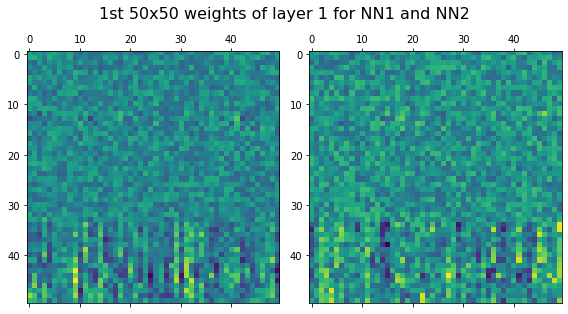

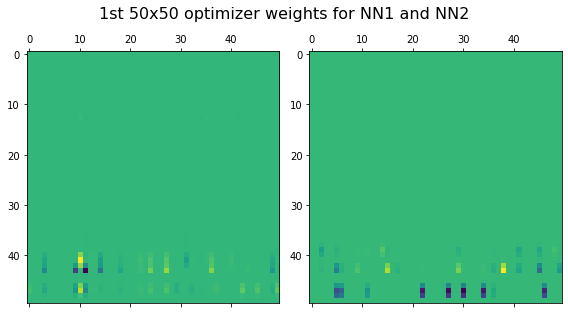

In [9]:
# First open arrays
model_array_1 = tiledb.open('tiledb-keras-mnist-sequential-1')[:]
model_array_2 = tiledb.open('tiledb-keras-mnist-sequential-2')[:]

# Load model weights
model_1_weights = pickle.loads(model_array_1['model_weights'].item(0))
model_2_weights = pickle.loads(model_array_2['model_weights'].item(0))

# Load optimizer weights
optimizer_1_weights = pickle.loads(model_array_1['optimizer_weights'].item(0))
optimizer_2_weights = pickle.loads(model_array_2['optimizer_weights'].item(0))

plt.rcParams["figure.figsize"] = (8,10)

# Maybe plot a part of layer 1 weights for both NNs
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('1st 50x50 weights of layer 1 for NN1 and NN2', size=16, y=0.72)
ax1.matshow(model_1_weights[0][:50, :50])
ax2.matshow(model_2_weights[0][:50, :50])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

# Maybe plot a part of optimizer weights for both NNs
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('1st 50x50 optimizer weights for NN1 and NN2', size=16, y=0.72)
ax1.matshow(optimizer_1_weights[1][:50, :50])
ax2.matshow(optimizer_2_weights[1][:50, :50])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Moving on, we can load the trained models for prediction or evaluation (we have to compile the model), as usual with
Tensorflow Keras models.

In [10]:
loaded_model_1 = tiledb_model_1.load()
loaded_model_2 = tiledb_model_2.load()

# Make some predictions
print(loaded_model_1.predict(x_test))
print(loaded_model_2.predict(x_test))

# Evaluate models
loaded_model_1 = tiledb_model_1.load(compile_model=True)
loaded_model_2 = tiledb_model_2.load(compile_model=True)
loaded_model_1.evaluate(x_test, y_test)
loaded_model_2.evaluate(x_test, y_test)

[[ -3.1672957   -4.651964     1.6712009  ...  10.25905     -2.0108116
   -2.4621236 ]
 [ -0.58136535   6.7989955   14.800443   ...  -9.551818     2.1335678
  -14.00117   ]
 [ -4.595273     6.450753     0.57370627 ...   0.24452654  -0.78677213
   -5.151593  ]
 ...
 [-10.279962   -11.098666    -6.357274   ...   0.50905573   0.79126227
    4.1145477 ]
 [ -4.4196      -3.3833222   -9.861209   ...  -3.7211566    1.7704382
   -8.049324  ]
 [  2.5385246   -9.441937    -5.4796467  ...  -8.828413    -4.891788
   -4.490574  ]]
[[ -7.0187726   -9.810473     0.36410165 ...   8.180393    -2.3503551
   -2.8052251 ]
 [ -3.5345027   -1.0479945    8.003188   ... -13.193698    -1.655436
  -12.528511  ]
 [ -5.4990582    4.3684993   -1.3456237  ...  -0.41590756  -1.5455275
   -5.9800873 ]
 ...
 [-11.71119    -10.044867    -8.16482    ...   0.42446685   0.38730848
    3.1547177 ]
 [ -4.3806744   -4.2459836   -7.999589   ...  -6.9943233    2.0465245
   -7.0111513 ]
 [ -1.6402203  -12.578906    -1.2772698  .

[0.10324851423501968, 0.9702000021934509]

What is really nice with saving models as TileDB array, is native versioning based on fragments as described
[here](https://docs.tiledb.com/main/concepts/data-format#immutable-fragments). We can load a model, retrain it
with new data and update the already existing TileDB model array with new model parameters and metadata. All information, old
and new will be there and accessible. This is extremely useful when you retrain with new data or trying different architectures
for the same problem, and you want to keep track of all your experiments without having to store different model instances. In our case,
let's continue training model_1 with the rest of our dataset and for 5 more epochs. After training is done, you will
notice the extra directories and files (fragments) added to tiledb-keras-mnist-sequential-1 TileDB array directory,
which keep all versions of the model.

In [11]:
loaded_model_1 = tiledb_model_1.load(compile_model=True)
loaded_model_1.fit(x_train[30000:], y_train[30000:], epochs=5)

# and update
tiledb_model_1 = TensorflowKerasTileDBModel(uri='tiledb-keras-mnist-sequential-1', model=loaded_model_1)
tiledb_model_1.save(include_optimizer=True,
                    update=True,
                    meta={"accuracy": model.history.history['accuracy'],
                          "loss": model.history.history['loss'],
                          "version": '0.0.1',
                          "status": 'experimental'})

# Check array directory
print()
pprint(glob.glob('tiledb-keras-mnist-sequential-1/*'))

# tiledb.array_fragments() requires TileDB-Py version > 0.8.5
fragments_info = tiledb.array_fragments('tiledb-keras-mnist-sequential-1')

print()
print("====== FRAGMENTS  INFO ======")
print("array uri: {}".format(fragments_info.array_uri))
print("number of fragments: {}".format(len(fragments_info)))

for fragment_num, fragment in enumerate(fragments_info, start=1):
    print()
    print("===== FRAGMENT NUMBER {} =====".format(fragment.num))
    print("fragment uri: {}".format(fragment.uri))
    print("timestamp range: {}".format(fragment.timestamp_range))
    print(
        "number of unconsolidated metadata: {}".format(
            fragment.unconsolidated_metadata_num
        )
    )
    print("version: {}".format(fragment.version))

Epoch 1/5
938/938 [==============================] - 1s 841us/step - loss: 0.1331 - accuracy: 0.9607
Epoch 2/5
938/938 [==============================] - 1s 839us/step - loss: 0.1031 - accuracy: 0.9688
Epoch 3/5
938/938 [==============================] - 1s 838us/step - loss: 0.0823 - accuracy: 0.9739
Epoch 4/5
938/938 [==============================] - 1s 1ms/step - loss: 0.0728 - accuracy: 0.9772
Epoch 5/5
938/938 [==============================] - 1s 895us/step - loss: 0.0631 - accuracy: 0.9800

['tiledb-keras-mnist-sequential-1/__meta',
 'tiledb-keras-mnist-sequential-1/__1651665865836_1651665865836_0b081537a5d14eb18b4cc58d114c38bd_11.ok',
 'tiledb-keras-mnist-sequential-1/__1651665855763_1651665855763_70b047b910874d89a4149e946261b411_11.ok',
 'tiledb-keras-mnist-sequential-1/__schema',
 'tiledb-keras-mnist-sequential-1/__1651665865836_1651665865836_0b081537a5d14eb18b4cc58d114c38bd_11',
 'tiledb-keras-mnist-sequential-1/__1651665855763_1651665855763_70b047b910874d89a4149e946261b411

Finally, a very interesting and useful, for machine learning models, TileDB feature that is described
[here](https://docs.tiledb.com/main/concepts/data-format#groups) and [here](https://docs.tiledb.com/main/how-to/object-management#creating-tiledb-groups)
are groups. Assuming we want to solve the MNIST problem, and we want to try several architectures. We can save each architecture
as a separate TileDB array with native versioning each time it is re-trained, and then organise all models that solve the same problem (MNIST)
as a TileDB array group with any kind of hierarchy. Let's firstly define a new model architecture.

In [12]:
def create_deeper_model():
    # For the sake of simplicity we just add an extra dense layer to the previous architecture.
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10)
    ])

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])

    return model

Then train it and save it as a new TileDB array.

In [13]:
model = create_deeper_model()
model.fit(x_train, y_train, epochs=5)

tiledb_deeper_model = TensorflowKerasTileDBModel(uri='tiledb-keras-mnist-sequential-deeper', model=model)

tiledb_deeper_model.save(include_optimizer=True,
                         update=False,
                         meta={"accuracy": model.history.history['accuracy'],
                               "loss": model.history.history['loss'],
                               "status": 'experimental'})

# Check array directory
print()
pprint(glob.glob('tiledb-keras-mnist-sequential-deeper/*'))

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2259 - accuracy: 0.9320
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0962 - accuracy: 0.9708
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0699 - accuracy: 0.9782
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0519 - accuracy: 0.9834
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0412 - accuracy: 0.9866

['tiledb-keras-mnist-sequential-deeper/__meta',
 'tiledb-keras-mnist-sequential-deeper/__1651665877075_1651665877075_aa54bfd2bc5a40f2a0cbf4ae3bd8dc51_11.ok',
 'tiledb-keras-mnist-sequential-deeper/__schema',
 'tiledb-keras-mnist-sequential-deeper/__1651665877075_1651665877075_aa54bfd2bc5a40f2a0cbf4ae3bd8dc51_11']


Now we can create a TileDB group and organise (in hierarchies, e.g., sophisticated vs less sophisticated) all our
MNIST models as follows.

In [14]:
tiledb.group_create('MNIST_Group')
os.system('mv tiledb-keras-mnist-sequential-1 MNIST_Group/')
os.system('mv tiledb-keras-mnist-sequential-2 MNIST_Group/')
os.system('mv tiledb-keras-mnist-sequential-deeper MNIST_Group/')

0

Any time we can check and query all the available models, including their metadata, for a specific problem like MNIST.

In [15]:
tiledb.ls('MNIST_Group', lambda obj_path, obj_type: print(obj_path, obj_type))

file:///Users/konstantinostsitsimpikos/tileroot/TileDB-ML/examples/models/MNIST_Group/tiledb-keras-mnist-sequential-1 array
file:///Users/konstantinostsitsimpikos/tileroot/TileDB-ML/examples/models/MNIST_Group/tiledb-keras-mnist-sequential-2 array
file:///Users/konstantinostsitsimpikos/tileroot/TileDB-ML/examples/models/MNIST_Group/tiledb-keras-mnist-sequential-deeper array


## Model Subclassing

Apart from being able to store models, which have been created with Symbolic APIs
(Sequential, Functional) someone can store models that are being designed based on
Imperative API (aka. Model Subclassing).

Let's first design a simple model:

In [16]:
from tensorflow import keras

class CustomModel(keras.Model):
    def __init__(self, hidden_units):
        super(CustomModel, self).__init__()
        self.hidden_units = hidden_units
        self.dense_layers = [keras.layers.Dense(u) for u in hidden_units]

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return x

    def get_config(self):
        return {"hidden_units": self.hidden_units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

Then we can create a trivial input dataset for testing the model. Remember that
for custom models to be initialised they need to be called on data.

In [17]:
model = CustomModel([16, 16, 10])
# Build the model by calling it
input_arr = tf.random.uniform((1, 5))
outputs = model(input_arr)

We then can save the model as a TileDB array.

In [18]:
tiledb_model_custom = TensorflowKerasTileDBModel(uri='tiledb-keras-custom-model', model=model)
tiledb_model_custom.save(include_optimizer=True, update=False)


Loading the subclassed model requires `custom_objects` to be passed as an argument
and the `input_shape` of the model so it can be built. The output of two models are
exactly the same

In [19]:
loaded_custom = tiledb_model_custom.load(custom_objects={"CustomModel": CustomModel}, input_shape=(1, 5))
outputs_loaded = loaded_custom(input_arr)
outputs == outputs_loaded

TileDBError: [TileDB::Filter] Error: FilterBuffer error; cannot init buffer: nullptr given.